In [169]:
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
mpl.rcParams['axes.unicode_minus'] = False 

df = pd.read_csv('Auto_data.csv',thousands = ',')

In [43]:
sns.set_context("talk")

In [2]:
# A simple classifier to adv programs
def label_the_data(df):
    df['adv_label'] = 0
    
    l_counter = 1
    crit_cols = ['车型','落地页', '媒体', '花费']
    i = 0
    j = 1
    df['adv_label'][0] = l_counter

    while i < df.shape[0]: 
        cur = i
        crit = list(df[crit_cols].iloc[i])
        
        while j < df.shape[0]:
            if list(df[crit_cols].iloc[j]) == crit:
                df['adv_label'][j] = l_counter    
            j += 1
        
        while cur<df.shape[0] and df['adv_label'][cur] != 0:
            cur += 1
        i = cur
        l_counter += 1
        
        df['adv_label'][i] = l_counter
        #print(i)
        j = i+1

In [156]:
# price to perfomance ratio "性价比"
# evaluated by number of exposure per unit money(CNY) spent
def get_perfomance(media_dict):
    out_df = pd.DataFrame(columns=['媒体类型', 'total_expo', 'expo_per_CNY', 'expo_4_6', 'expo_7_9', 
                                'total_click', 'click_per_CNY', 'click_4_6', 'click_7_9', 'click_per_expo',
                                  'total_sales_clue', 'sales_clue_per_CNY', 'sales_clue_4_6', 'sales_clue_7_9'])
    
    for i in media_dict.keys():
        
        temp = media_dict[i]
        
        expo = temp['expo_per_CNY'].mean()
        total_expo = temp['real_expo'].sum()

        click = temp['click_per_CNY'].mean()
        total_click = temp['real_click'].sum()
        
        sales_clue = temp['sales_clue_per_CNY'].mean()
        total_sales_clue = temp['销售线索量'].sum()
        
        expo_4_6 = temp[temp['数据日期']<=20190630]['expo_per_CNY'].mean()
        expo_7_9 = temp[20190701<=temp['数据日期']]['expo_per_CNY'].mean()

        click_4_6 = temp[temp['数据日期']<=20190630]['click_per_CNY'].mean()
        click_7_9 = temp[20190701<=temp['数据日期']]['click_per_CNY'].mean()
        
        sc_4_6 = temp[temp['数据日期']<=20190630]['销售线索量'].mean()
        sc_7_9 = temp[20190701<=temp['数据日期']]['销售线索量'].mean()
        
        
        cpe = temp['click_per_expo'].mean()
        
   #     if temp['落地页'][0] == '官网':
         #   out_df.loc[i] = (list(media_dict[i]['媒体类型'])[0],
       #                  expo, expo_4_6,expo_7_9, click, click_4_6, click_7_9, cpe)
        
        out_df.loc[i] = (list(media_dict[i]['媒体类型'])[0],
                         total_expo, expo, expo_4_6,expo_7_9, 
                         total_click, click, click_4_6, click_7_9, cpe, 
                         total_sales_clue, sales_clue, sc_4_6, sc_7_9)
    
        
    return out_df

In [4]:
# select data for each media

# This line is just for a ez view
# cols = ['媒体', '数据日期', '花费', '预估日曝光量', '预估日点击量', '曝光量', '点击量', '异常曝光量', '异常点击量', 'real_expo', 'pct_real']
def select_by_media(df):
    media_dict = {}
    for i in df['媒体'].value_counts().keys():
        media_dict[i] = df[df['媒体'] == i]
    return media_dict

In [5]:
# some data cleaning
cols = df.loc[:,'查询经销商按钮用户数':'销售线索量'].columns
df = df.replace('-', np.nan)
for i in cols:
    try:
        df[i] = df[i].str.replace(',', '').astype(float)
    except:
        continue
        
for i in range(df.shape[0]):
    df.loc[:,'媒体'][i] = df.loc[:,'媒体'][i].replace('媒体', 'Media ')

In [6]:
label_the_data(df)

In [171]:
df['real_expo'] = df['曝光量']-df['异常曝光量'] # real exposure that exclude abnormal exposure
df['real_click'] = df['点击量'] - df['异常点击量']
df['pct_real'] = df['real_expo']/df['预估日曝光量'] # % real exposure of expected
df['click_per_expo'] = df['real_click']/df['real_expo']
df['Qtr'] = np.where(df['数据日期']<20190701,'Q2','Q3')

In [8]:
# calculate the number of exposure per unit money(CNY) spent
cost_dict = {}
for i in df['adv_label'].unique():
    
    boo = df['adv_label']==i
    
    total_expo = df[boo]['real_expo'].sum()
    cost = df[boo]['花费'].mean() # not necessarily to use .mean()
    
    if cost == 500:
        cost = 500*df[boo].shape[0]
    
    total_click = df[boo]['real_click'].sum()
    total_sales_clue = df[boo]['销售线索量'].sum()
    
    df.loc[boo,'expo_per_CNY'] = total_expo/cost
    df.loc[boo,'click_per_CNY'] = total_click/cost
    df.loc[boo,'sales_clue_per_CNY'] = total_sales_clue/cost
    
    cost_dict[i] = [cost, df[boo]['落地页'].unique()[0], df[boo]['Qtr'].unique()[0]]

In [174]:
# Find medias whose total exposure less than expected
media_dict = select_by_media(df)
for i in media_dict.keys():
    media_dict[i] = [media_dict[i], media_dict[i]['预估日曝光量'].sum(), media_dict[i]['real_expo'].sum()]
        
print('总量不达标的媒体有：')
for i in media_dict.keys():
    if media_dict[i][1]*0.8 > media_dict[i][2]:
        print(i, end='\t')

总量不达标的媒体有：
媒体1	媒体5	媒体18	媒体22	

In [57]:
# just for take a look
# 落地页分类:
# 专题无相关数据
# The part 查询数：销售线索量 is highly unmatched with the 
df[df['落地页']=='官网'].loc[:,'访问次数':'销售线索量'].sum()

访问次数           22635434.0
独立访客           22321678.0
独立新访客          21153945.0
浏览量            26449837.0
浏览时长          729452208.0
跳出次数           17927085.0
查询经销商按钮用户数        21704.0
查询经销商按钮次数         22322.0
预约试驾按钮用户数         11368.0
预约试驾按钮次数          18589.0
在线客服按钮用户数         10444.0
在线客服按钮次数          10672.0
销售线索量             34159.0
dtype: float64

In [58]:
# Take a look on coefficients
# 
df[df['落地页']=='官网'].loc[:,'曝光量':'销售线索量'].corr()

,曝光量,点击量,异常曝光量,异常点击量,访问次数,独立访客,独立新访客,浏览量,浏览时长,跳出次数,查询经销商按钮用户数,查询经销商按钮次数,预约试驾按钮用户数,预约试驾按钮次数,在线客服按钮用户数,在线客服按钮次数,销售线索量
曝光量,1.000000,0.554929,0.793202,0.415114,0.531087,0.532342,0.529804,0.557095,0.377466,0.492043,0.054943,0.056007,0.324723,0.227426,0.149010,0.150524,0.187204
点击量,0.554929,1.000000,0.390148,0.769659,0.948053,0.946933,0.941280,0.945479,0.611728,0.943491,-0.039741,-0.036605,0.071787,0.108180,-0.020431,-0.018131,0.130056
异常曝光量,0.793202,0.390148,1.000000,0.466784,0.337222,0.337753,0.333313,0.354976,0.287982,0.296497,0.027235,0.028703,0.298920,0.229573,0.124902,0.125693,-0.005412
异常点击量,0.415114,0.769659,0.466784,1.000000,0.711136,0.710492,0.705102,0.706652,0.494425,0.705396,-0.046000,-0.043606,0.035209,0.073129,-0.029643,-0.028492,0.085443
访问次数,0.531087,0.948053,0.337222,0.711136,1.000000,0.999929,0.998836,0.994824,0.697631,0.980537,-0.008108,-0.006278,0.098238,0.141518,0.025079,0.027251,0.217101
独立访客,0.532342,0.946933,0.337753,0.710492,0.999929,1.000000,0.999182,0.994545,0.696545,0.980222,-0.006830,-0.004998,0.099589,0.142653,0.026799,0.028968,0.219908
独立新访客,0.529804,0.941280,0.333313,0.705102,0.998836,0.999182,1.000000,0.992295,0.695738,0.978891,-0.002437,-0.000607,0.104184,0.146899,0.032537,0.034706,0.224751
浏览量,0.557095,0.945479,0.354976,0.706652,0.994824,0.994545,0.992295,1.000000,0.706326,0.967490,0.039425,0.041499,0.099275,0.134215,0.054845,0.057381,0.219046
浏览时长,0.377466,0.611728,0.287982,0.494425,0.697631,0.696545,0.695738,0.706326,1.000000,0.589893,0.123717,0.124996,0.084376,0.143512,0.141205,0.143158,0.194799
跳出次数,0.492043,0.943491,0.296497,0.705396,0.980537,0.980222,0.978891,0.967490,0.589893,1.000000,-0.046240,-0.044300,0.075201,0.120523,-0.038298,-0.036283,0.194365


In [59]:
# there are four combinations for the advertising

df_ts_pc = df[df['落地页']=='专题'][df['端口']=='PC']
df_ts_mob = df[df['落地页']=='专题'][df['端口']=='Mobile']

df_web_pc = df[df['落地页']=='官网'][df['端口']=='PC']
df_web_mob = df[df['落地页']=='官网'][df['端口']=='Mobile']

In [60]:
# 专题     官网
# pc      mobile

In [75]:
pfm_ts_pc = get_perfomance(select_by_media(df_ts_pc))
pfm_ts_pc.sort_values(by='expo_per_CNY', ascending = False)
pfm_ts_pc.to_csv('tp_pc.csv')
pfm_ts_pc

,媒体类型,total_expo,expo_per_CNY,expo_4_6,expo_7_9,total_click,click_per_CNY,click_4_6,click_7_9,click_per_expo,total_sales_clue,sales_clue_per_CNY,sales_clue_4_6,sales_clue_7_9
Media 23,汽车垂直,435066445,1249.683995,1249.683995,NaN,2536403,7.884455,7.884455,NaN,0.008070,0.0,0.0,0.0,NaN
Media 13,汽车垂直,56305864,167.329138,167.329138,NaN,113723,0.043499,0.043499,NaN,0.001224,0.0,0.0,0.0,NaN
Media 16,汽车垂直,57470679,118.678573,118.678573,NaN,328115,1.108540,1.108540,NaN,0.005466,0.0,0.0,0.0,NaN
Media 6,汽车垂直,2392520,47.850400,47.850400,NaN,14078,0.281560,0.281560,NaN,0.005899,0.0,0.0,0.0,NaN


In [62]:
pfm_ts_pc['媒体'] = pfm_ts_pc.index

In [165]:
import seaborn as sns
def hist_plot(df,content,ylb,title='1.png'):
    
    sns.set(style="whitegrid")
    df['Media'] = df.index
    box = sns.barplot(x='Media', y=content, ci=0, data=df)
    box.set(ylabel = ylb)
    box.figure.savefig(title)

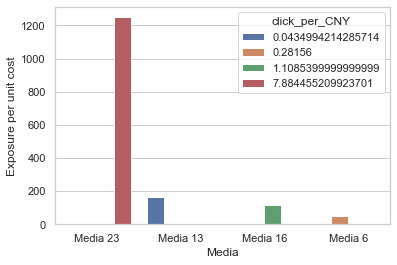

In [110]:
hist_plot(pfm_ts_pc,'expo_per_CNY','Exposure per unit cost','tp_pc.png')

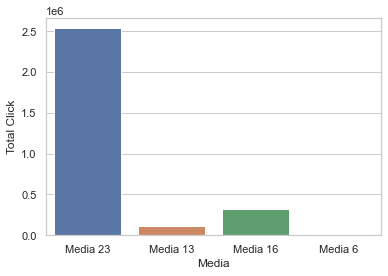

In [81]:
hist_plot(pfm_ts_pc,'total_click','Total Click','tp_pc_total_c.png')

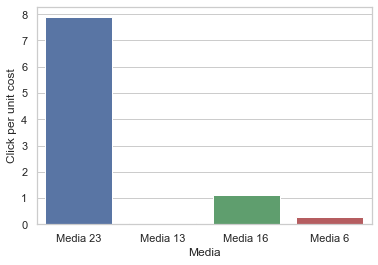

In [82]:
hist_plot(pfm_ts_pc,'click_per_CNY','Click per unit cost','tp_pc_click.png')

In [72]:
pfm_ts_mob = get_perfomance(select_by_media(df_ts_mob))
pfm_ts_mob.sort_values(by='expo_per_CNY', ascending = False)
pfm_ts_mob.to_csv('tp_mob.csv')
pfm_ts_mob

,媒体类型,total_expo,expo_per_CNY,expo_4_6,expo_7_9,total_click,click_per_CNY,click_4_6,click_7_9,click_per_expo,total_sales_clue,sales_clue_per_CNY,sales_clue_4_6,sales_clue_7_9
Media 23,汽车垂直,200522658,452.210560,452.210560,NaN,1676187,3.002667,3.002667,NaN,0.007268,0.0,0.0,0.0,NaN
Media 7,汽车垂直,120585080,618.469771,618.469771,NaN,211210,0.840341,0.840341,NaN,0.001554,0.0,0.0,0.0,NaN
Media 13,汽车垂直,174522738,244.595506,244.595506,NaN,141554,0.051913,0.051913,NaN,0.002314,0.0,0.0,0.0,NaN
Media 16,汽车垂直,88531448,122.899561,122.899561,NaN,1284820,1.441113,1.441113,NaN,0.012826,0.0,0.0,0.0,NaN


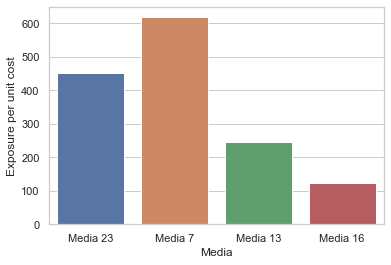

In [86]:
hist_plot(pfm_ts_mob,'expo_per_CNY','Exposure per unit cost','tp_mob.png')

In [89]:
pfm_web_pc = get_perfomance(select_by_media(df_web_pc))
pfm_web_pc = pfm_web_pc.sort_values(by='expo_per_CNY', ascending = False)
pfm_web_pc.to_csv('web_pc.csv')
pfm_web_pc

,媒体类型,total_expo,expo_per_CNY,expo_4_6,expo_7_9,total_click,click_per_CNY,click_4_6,click_7_9,click_per_expo,total_sales_clue,sales_clue_per_CNY,sales_clue_4_6,sales_clue_7_9
Media 1,视频,753153,2123.961687,2123.961687,NaN,2448,53.145547,53.145547,NaN,0.006088,0.0,3.733333e-04,3.733333e-04,NaN
Media 5,视频,12974205,912.730594,912.730594,NaN,31985,12.775059,12.775059,NaN,0.002435,0.0,0.000000e+00,0.000000e+00,NaN
Media 19,其他,116873996,230.941926,230.941926,NaN,731191,1.410392,1.410392,NaN,0.006329,1.0,3.888889e-07,3.888889e-07,NaN
Media 9,其他,13251088,105.735801,105.735801,NaN,277834,1.719851,1.719851,NaN,0.029729,93.0,2.411111e-04,2.411111e-04,NaN
Media 14,其他,17031270,78.187295,78.187295,NaN,94157,0.428464,0.428464,NaN,0.009288,0.0,0.000000e+00,0.000000e+00,NaN


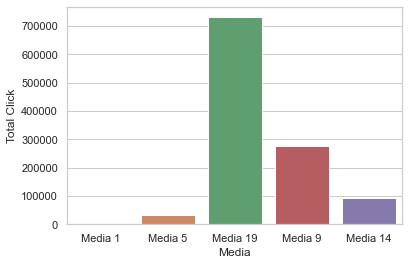

In [166]:
hist_plot(pfm_web_pc,'total_click','Total Click','web_pc_total_c.png')

In [158]:
pfm_web_mob = get_perfomance(select_by_media(df_web_mob))
pfm_web_mob = pfm_web_mob.sort_values(by='expo_4_6', ascending = False)
pfm_web_mob.to_csv('web_mob.csv')
pfm_web_mob

,媒体类型,total_expo,expo_per_CNY,expo_4_6,expo_7_9,total_click,click_per_CNY,click_4_6,click_7_9,click_per_expo,total_sales_clue,sales_clue_per_CNY,sales_clue_4_6,sales_clue_7_9
Media 3,视频,137071164,5076.709778,5076.709778,NaN,2248548,83.279556,83.279556,NaN,0.016168,37.0,0.001370,2.642857,NaN
Media 1,视频,245135393,4750.788707,4750.788707,NaN,6184822,118.541916,118.541916,NaN,0.029280,42.0,0.000847,2.470588,NaN
Media 10,门户,432427548,4144.615468,2066.385967,6180.432122,10015438,98.429586,67.804871,128.429306,0.016041,6081.0,0.057497,73.577778,56.530612
Media 5,视频,79025520,1527.565213,1527.565213,NaN,1174455,21.453636,21.453636,NaN,0.015047,0.0,0.000000,0.000000,NaN
Media 21,门户,360742436,2214.071507,275.553075,8558.313648,2376634,12.645240,0.780667,51.474755,0.006334,4851.0,0.070873,73.093750,228.363636
Media 20,门户,213351786,204.058368,236.620724,153.734726,1015025,0.931980,1.067954,0.721839,0.004861,6885.0,0.007015,225.058824,278.090909
Media 15,门户,110964992,3781.201078,23.873754,8289.993867,2750312,86.251182,0.629611,188.997067,0.025984,9754.0,0.350468,221.055556,385.000000
Media 11,其他,10406365,15.217462,15.217462,NaN,607723,0.932323,0.932323,NaN,0.060914,0.0,0.000000,NaN,NaN
Media 22,社交,141471918,14.147192,14.147192,NaN,441930,0.044193,0.044193,NaN,0.003116,403.0,0.000040,40.300000,NaN
Media 2,其他,37496381,12.498794,12.498794,NaN,741760,0.247253,0.247253,NaN,0.019088,32.0,0.000011,10.666667,NaN


In [159]:
pfm_web_mob.index = ['M'+x[6:] for x in pfm_web_mob.index]
pfm_web_mob

,媒体类型,total_expo,expo_per_CNY,expo_4_6,expo_7_9,total_click,click_per_CNY,click_4_6,click_7_9,click_per_expo,total_sales_clue,sales_clue_per_CNY,sales_clue_4_6,sales_clue_7_9
M3,视频,137071164,5076.709778,5076.709778,NaN,2248548,83.279556,83.279556,NaN,0.016168,37.0,0.001370,2.642857,NaN
M1,视频,245135393,4750.788707,4750.788707,NaN,6184822,118.541916,118.541916,NaN,0.029280,42.0,0.000847,2.470588,NaN
M10,门户,432427548,4144.615468,2066.385967,6180.432122,10015438,98.429586,67.804871,128.429306,0.016041,6081.0,0.057497,73.577778,56.530612
M5,视频,79025520,1527.565213,1527.565213,NaN,1174455,21.453636,21.453636,NaN,0.015047,0.0,0.000000,0.000000,NaN
M21,门户,360742436,2214.071507,275.553075,8558.313648,2376634,12.645240,0.780667,51.474755,0.006334,4851.0,0.070873,73.093750,228.363636
M20,门户,213351786,204.058368,236.620724,153.734726,1015025,0.931980,1.067954,0.721839,0.004861,6885.0,0.007015,225.058824,278.090909
M15,门户,110964992,3781.201078,23.873754,8289.993867,2750312,86.251182,0.629611,188.997067,0.025984,9754.0,0.350468,221.055556,385.000000
M11,其他,10406365,15.217462,15.217462,NaN,607723,0.932323,0.932323,NaN,0.060914,0.0,0.000000,NaN,NaN
M22,社交,141471918,14.147192,14.147192,NaN,441930,0.044193,0.044193,NaN,0.003116,403.0,0.000040,40.300000,NaN
M2,其他,37496381,12.498794,12.498794,NaN,741760,0.247253,0.247253,NaN,0.019088,32.0,0.000011,10.666667,NaN


In [163]:
def hist_plot(df,content,ylb,title='1.png'):
    
    sns.set(style="whitegrid")
    df['Media'] = df.index
    box = sns.barplot(x='Media', y=content[1], hue=content[0], ci=0, data=df)
    box.set(ylabel = ylb)
    box.figure.savefig(title)

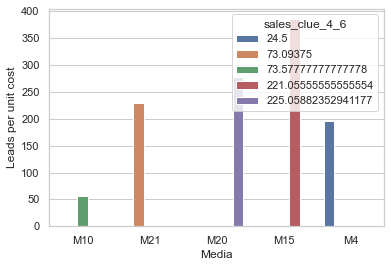

In [164]:
hist_plot(pfm_web_mob.dropna(),['sales_clue_4_6', 'sales_clue_7_9'],'Leads per unit cost','web_mob_sales_qtr.png')

In [18]:
# 预算
cost_dict['专题_total'], cost_dict['官网_total'], cost_dict['Q2_total'], cost_dict['Q3_total'] = (0,0,0,0)
for i in cost_dict:
    if not isinstance(i,np.int64):
        break
        
    j = cost_dict[i]
    
    if j[1] == '专题':
        cost_dict['专题_total'] += j[0]
    else:
        cost_dict['官网_total'] += j[0]
        
    if j[2] == 'Q2':
        cost_dict['Q2_total'] += j[0]
    else:
        cost_dict['Q3_total'] += j[0]
        
cost_dict['total'] = cost_dict['Q2_total'] + cost_dict['Q3_total']

In [19]:
print('专题\t 官网     Q2     Q3')
print(cost_dict['专题_total'],cost_dict['官网_total'], cost_dict['Q2_total'], cost_dict['Q3_total'])

专题	 官网     Q2     Q3
13600000.0 55450000.0 66001500.0 3048500.0
